In [1]:
import os, sys
import numpy as np
import pandas as pd
import PIL
from PIL import Image

import torch
import scipy.spatial

sys.path.append('/user_data/mmhender/featsynth/')

from code_imageanalysis import extract_resnet_features
from code_utils import stats_utils

import matplotlib.pyplot as plt
from matplotlib import cm

things_root = '/user_data/mmhender/stimuli/things/'
project_root = '/user_data/mmhender/featsynth/'
stimuli_folder = 'images_v1'


/home/mmhender/imstat_env/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


device = cpu:0


#### Load resnet features from the original things images

In [2]:
# from code_imageanalysis import prep_images
# folder_save = os.path.join(project_root, 'features','raw')
# image_list = prep_images.make_image_list()
image_set_name = 'images_expt1'
# image_list_filename = os.path.join(folder_save, '%s_list.csv'%(image_set_name))
# print('saving to %s'%image_list_filename)
# image_list.to_csv(image_list_filename)

folder_save = os.path.join(project_root, 'features','raw')
image_list_filename = os.path.join(folder_save, '%s_list.csv'%(image_set_name))

labels = pd.read_csv(image_list_filename)

feat_path = os.path.join(project_root, 'features', 'resnet')
image_set_name = 'images_expt1'
training_type='imgnet'
feat_all = []

for ll in [2,6]:
# for ll in [2,6,12,15]:

    feat_file_name = os.path.join(feat_path, \
                                          '%s_%s_block%d_pca.npy'%(image_set_name,\
                                                                   training_type, \
                                                                   ll))
    print(feat_file_name)
    feat = np.load(feat_file_name)
    
    feat_all += [feat]
    
feat_all = np.concatenate(feat_all, axis=1)
feat = feat_all

/user_data/mmhender/featsynth/features/resnet/images_expt1_imgnet_block2_pca.npy
/user_data/mmhender/featsynth/features/resnet/images_expt1_imgnet_block6_pca.npy


In [17]:
feat.shape

(2400, 1000)

In [3]:
n_ims_each = np.sum(np.array(labels['basic_name'])==np.array(labels['basic_name'])[0])
basic_names = np.array(labels['basic_name'][0::n_ims_each])
# assert(np.all(list(np.array(basic_names_eachset).ravel())==basic_names))
super_names_long = np.array(labels['super_name'][0::n_ims_each])
basic_inds = np.array(labels['basic_index'][0::n_ims_each])
super_inds_long = np.array(labels['super_index'][0::n_ims_each])
n_basic = len(basic_names)
n_super = len(np.unique(super_names_long))
n_basic_each_super  = int(n_basic/n_super)
super_names = super_names_long[0::n_basic_each_super]
super_cbinds = np.repeat(np.array([0,1]), n_basic_each_super)
super_cbinds

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

#### Compute category separability based on cosine dist

In [4]:
within_b = np.zeros((n_basic,))
across_b_within_s = np.zeros((n_basic,))

for bi in range(n_basic):
    
    inds = np.array(labels['basic_index'])==bi
    f = feat[inds,:]

    # comparing images from the same basic-level category
    d = scipy.spatial.distance.pdist(f, metric='cosine')
    
    # average across all pairwise comparisons
    within_b[bi] = np.mean(d.ravel())
    
    # now find all images that are in same super-ordinate category but different basic-level
    si = super_inds_long[bi]
    inds2 = (labels['basic_index']!=bi) & (labels['super_index']==si)
   
    f2 = feat[inds2,:]
    
    # comparing images from same superordinate, different basic-level
    d = scipy.spatial.distance.cdist(f, f2, metric='cosine')

    # average over all pairwise comparisons
    across_b_within_s[bi] = np.mean(d.ravel())
        

# get ratio of across to within
basic_sep = across_b_within_s / within_b 

# average across all the basic-level categs in each super-level
basic_sep_each_supcat = np.array([np.mean(basic_sep[super_inds_long==si]) for si in range(n_super)])

In [5]:
within_s = np.zeros((n_super,))
across_s = np.zeros((n_super,))

for si in range(n_super):
    
    inds = np.array(labels['super_index'])==si
    f = feat[inds,:]

    # comparing images from the same super-level category
    d = scipy.spatial.distance.pdist(f, metric='cosine')
    
    # average across all pairwise comparisons
    within_s[si] = np.mean(d.ravel())
    
    inds2 = np.array(labels['super_index'])!=si
    
    f2 = feat[inds2,:]

    # comparing images from diff super-level
    d = scipy.spatial.distance.cdist(f, f2, metric='cosine')

    # average over all pairwise comparisons
    across_s[si] = np.mean(d.ravel())

# compute ratio of across / within
super_sep_each_supcat = across_s / within_s


#### Load behavioral data here

In [6]:
expt_name = 'expt1'
data_folder = os.path.join(project_root, 'online_data', expt_name)
expt_design_folder = os.path.join(project_root, 'expt_design', expt_name)
preproc_folder = os.path.join(data_folder, 'preproc')
data_filename = os.path.join(preproc_folder, 'preproc_data_all.csv')
trial_data_all = pd.read_csv(data_filename)
subjects = np.unique(trial_data_all['subject'])
n_subjects = len(subjects)
subject_cb = np.array([np.array(trial_data_all['which_cb'])[trial_data_all['subject']==si][0] \
              for si in subjects]) - 1

# check that the super-category names align across behavioral data and image analyses
for which_cb in [0,1]:
    subject_check = subjects[np.where(subject_cb==which_cb)[0][0]]
    trial_data = trial_data_all[trial_data_all['subject']==subject_check]
    scheck = np.unique(trial_data['super_name'])
    assert(np.all(scheck==super_names[super_cbinds==which_cb]))
    

In [7]:
# figure out condition labels, categorization level & image type
cue_level_vals = ['basic','super']
assert(np.all(np.unique(np.array(trial_data_all['cue_level']))==cue_level_vals))
n_cue_levels = len(cue_level_vals)
print(cue_level_vals)

image_type_nums = np.unique(np.array(trial_data_all['image_type_num']))
n_image_types = len(image_type_nums)
image_type_names = [trial_data_all['image_type'][trial_data_all['image_type_num']==it].iloc[0] for it in image_type_nums]
type_order_plot = [1,2,3,4,0]
image_type_names = np.array(image_type_names)[type_order_plot]
print(image_type_names)

# for plotting
cue_level_colors = np.array([[93,192,219], [44,92,168]])/255
point_types = ['o','x']


['basic', 'super']
['pool1' 'pool2' 'pool3' 'pool4' 'orig']


#### Compute accuracy within each individual categ

In [8]:
acc_by_supcat = [np.full(fill_value = np.nan, \
                         shape = (np.sum(subject_cb==cb), n_cue_levels, n_image_types, int(n_super/2))) \
                 for cb in [0,1]]
acc_by_bascat = [np.full(fill_value = np.nan, \
                         shape = (np.sum(subject_cb==cb), n_cue_levels, n_image_types, int(n_super/2), n_basic_each_super)) \
                 for cb in [0,1]]
cb_sub_count = [-1,-1]

for si, ss in enumerate(subjects):
    
    cbi = subject_cb[si]
   
    cb_sub_count[cbi]+=1
    
    trial_data = trial_data_all[trial_data_all['subject']==ss]

    supnames = super_names[super_cbinds==cbi]
      
    for sc, supcat in enumerate(supnames):

        for cc, cue in enumerate(cue_level_vals):

            for ii, imtype in enumerate(image_type_names):

                inds = (trial_data['cue_level']==cue) & \
                        (trial_data['image_type']==imtype) & \
                        (trial_data['super_name']==supcat)
                assert(np.sum(inds)==10)
                
                acc_by_supcat[cbi][cb_sub_count[cbi],cc,ii,sc] = np.mean(np.array(trial_data['correct'])[inds])

                bnames = basic_names[super_names_long==supcat]
                
                for bb, bascat in enumerate(bnames):
                    
                    inds_basic = inds & (trial_data['basic_name']==bascat)
                    assert(np.sum(inds_basic)==1)

                    acc_by_bascat[cbi][cb_sub_count[cbi],cc,ii,sc,bb] = \
                        np.mean(np.array(trial_data['correct'])[inds_basic])

                    
                    n_each_cb = np.array([np.sum(subject_cb==cb) for cb in [0,1]])
assert(np.all(n_each_cb == np.array(cb_sub_count)+1))
assert(not np.any([np.any(np.isnan(a)) for a in acc_by_supcat]))
assert(not np.any([np.any(np.isnan(a)) for a in acc_by_bascat]))


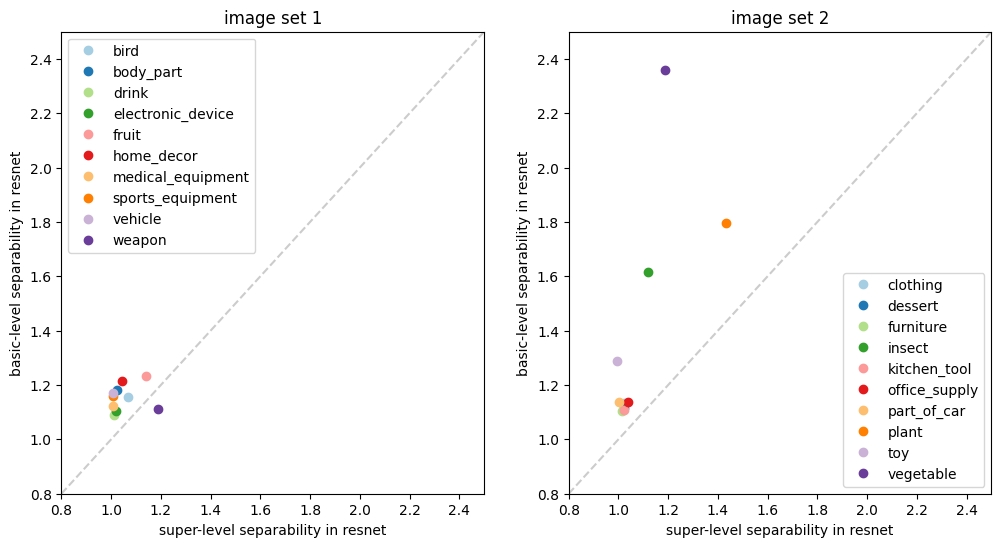

In [9]:
plt.figure(figsize=(12,6))

lims = [0.8, 2.5]

pi=0
for cbi in [0,1]:
        
    pi+=1
    ax = plt.subplot(1,2,pi)
        
    
    supnames = super_names[super_cbinds==cbi]
    
    dist1 = super_sep_each_supcat[super_cbinds==cbi]
    dist2 = basic_sep_each_supcat[super_cbinds==cbi]

    assert(np.all(dist1<lims[1]) & np.all(dist1>lims[0]))
    assert(np.all(dist2<lims[1]) & np.all(dist2>lims[0]))

    basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
    # markertypes = np.tile(['.','x','^'],4) 
    markertypes = np.tile(['o'],10) 
    allh = []
    # for bi in [9]:
    for bi in range(len(dist1)):
        
        h, = plt.plot(dist1[bi], dist2[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
    
        allh+=[h]
        
    plt.title('image set %d'%(cbi+1))

    plt.xlabel('super-level separability in resnet')
    plt.ylabel('basic-level separability in resnet')

    plt.xlim(lims)
    plt.ylim(lims)
    
    plt.plot(lims,lims, color=[0.8, 0.8, 0.8], linestyle='--')
    
    plt.legend(allh, supnames)

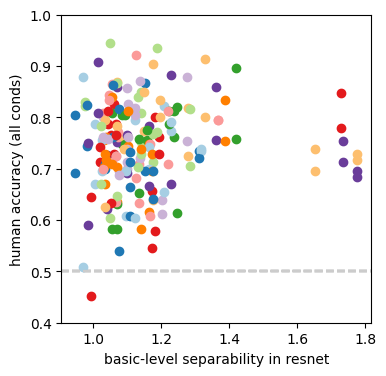

In [11]:
plt.figure(figsize=(4,4))

for cbi in [0,1]:

    supnames = super_names[super_cbinds==cbi]

    for sc, supcat in enumerate(supnames):
    
        bnames = basic_names[super_names_long==supcat]
       
        # [subjects x cue_levels x image_types x basic_categ]
        vals = acc_by_bascat[cbi][:,:,:,sc,:]
        plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        n_subs_plot = vals.shape[0]

        dist = basic_sep[super_inds_long==sc]

        basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
        # markertypes = np.tile(['.','x','^'],4) 
        markertypes = np.tile(['o'],10) 
        # allh = []
        for bi in range(len(dist)):

            h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
            # plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

            # allh+=[h]

        # plt.title('%s'%(supcat))

        plt.ylim([0.4, 1.0])
        plt.xlabel('basic-level separability in resnet')
        plt.ylabel('human accuracy (all conds)')
           
        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        # box = ax.get_position()
        # ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        # ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

        # plt.legend(allh, bnames)

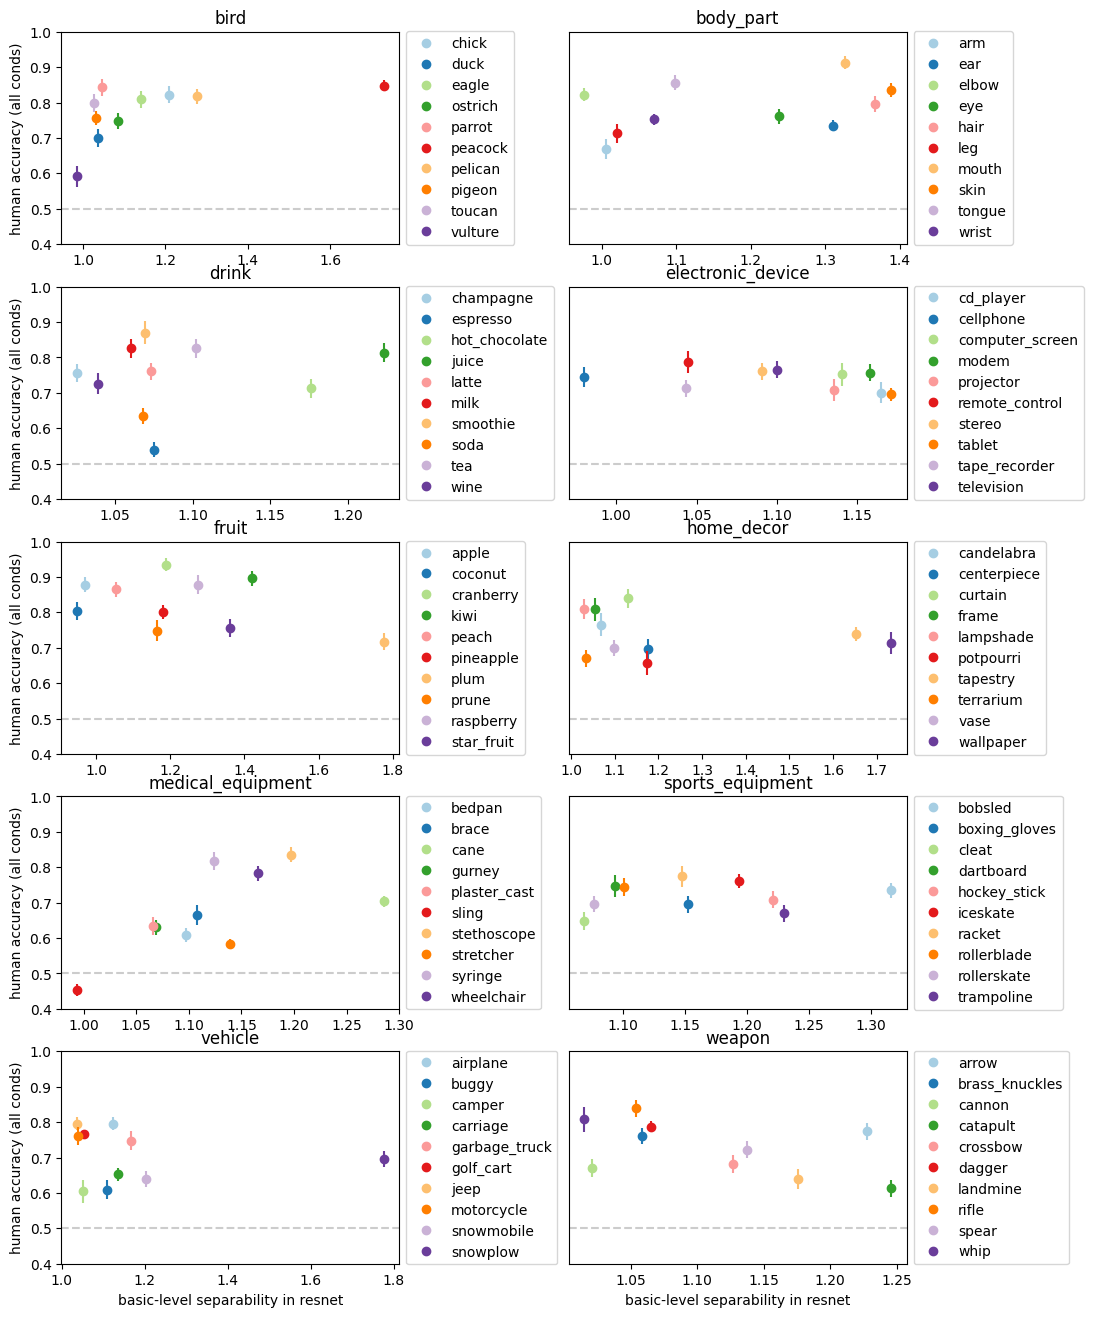

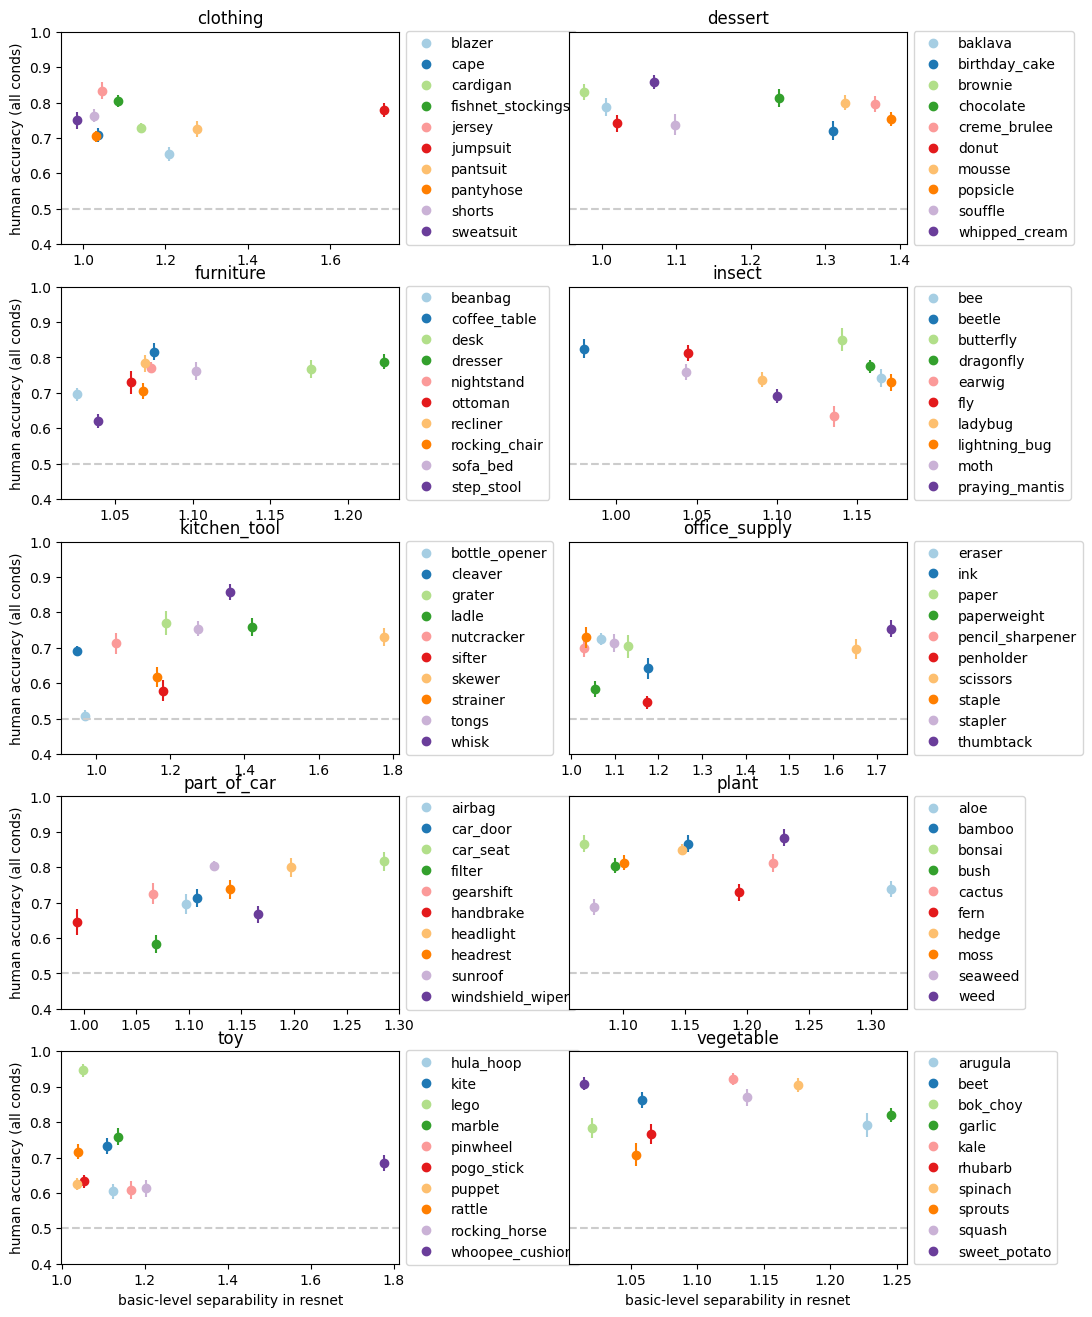

In [12]:
for cbi in [0,1]:
    
    supnames = super_names[super_cbinds==cbi]
      
    plt.figure(figsize=(12,16))

    pi=0
    
    for sc, supcat in enumerate(supnames):
    
        bnames = basic_names[super_names_long==supcat]
                
        pi+=1
        ax = plt.subplot(5,2,pi)

        # [subjects x cue_levels x image_types x basic_categ]
        vals = acc_by_bascat[cbi][:,:,:,sc,:]
        plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        n_subs_plot = vals.shape[0]

        dist = basic_sep[super_inds_long==sc]

        basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
        # markertypes = np.tile(['.','x','^'],4) 
        markertypes = np.tile(['o'],10) 
        allh = []
        for bi in range(len(dist)):

            h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
            plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

            allh+=[h]

        plt.title('%s'%(supcat))

        plt.ylim([0.4, 1.0])
        # plt.xlim([1.0, 2.5])
        if sc>7:
            plt.xlabel('basic-level separability in resnet')
        if np.mod(sc,2)==0:
            plt.ylabel('human accuracy (all conds)')
        else:
            plt.yticks([])
            
        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

        # plt.legend(allh, bnames)

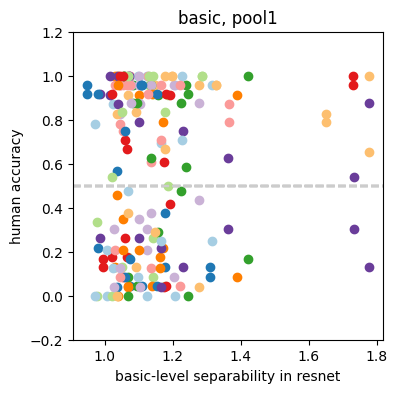

In [13]:
cc = 0;
ii = 0;

plt.figure(figsize=(4,4))

for cbi in [0,1]:
    
    supnames = super_names[super_cbinds==cbi]
     
    for sc, supcat in enumerate(supnames):
    
        bnames = basic_names[super_names_long==supcat]
       
        # [subjects x basic_categ]
        vals = acc_by_bascat[cbi][:,cc,ii,sc,:]
        # plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
        plot_vals = vals
        meanvals = np.mean(plot_vals, axis=0)
        # semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        n_subs_plot = vals.shape[0]

        dist = basic_sep[super_inds_long==sc]

        basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
        # markertypes = np.tile(['.','x','^'],4) 
        markertypes = np.tile(['o'],10) 
        # allh = []
        for bi in range(len(dist)):

            h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
            # plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

            # allh+=[h]

        # plt.title('%s'%(supcat))

        plt.ylim([-0.2, 1.2])
        plt.xlabel('basic-level separability in resnet')
        plt.ylabel('human accuracy')
           
        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

#         box = ax.get_position()
#         ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

#         # Put a legend to the right of the current axis
#         ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.title('%s, %s'%(cue_level_vals[cc], image_type_names[ii]))
        # plt.legend(allh, bnames)

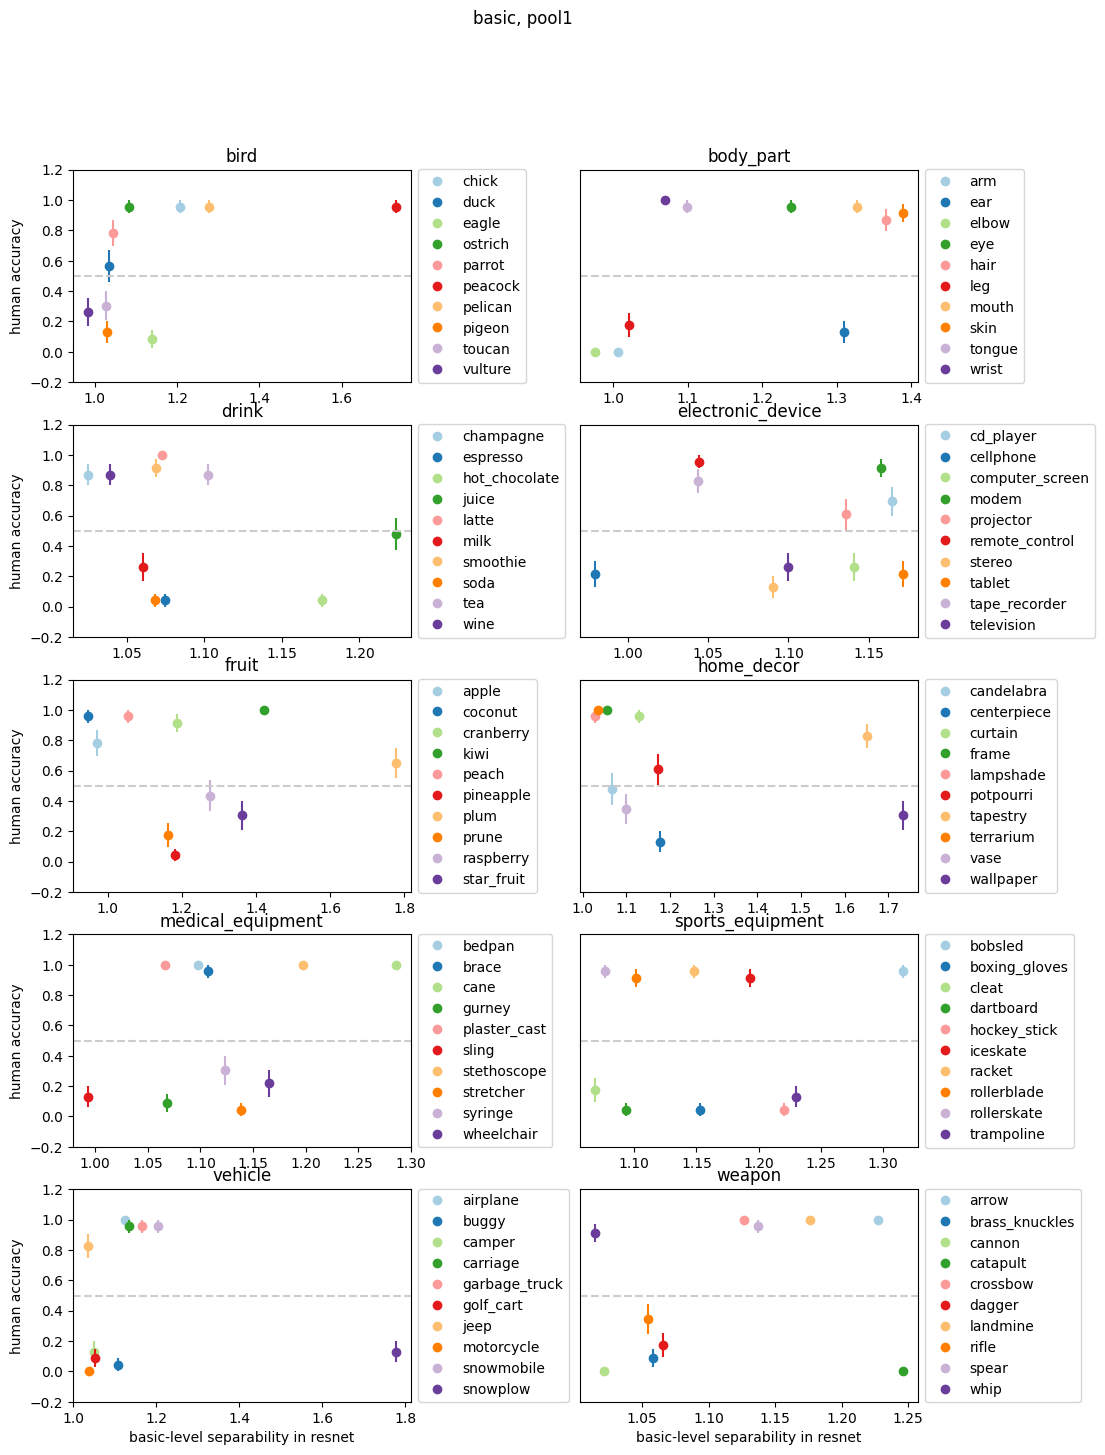

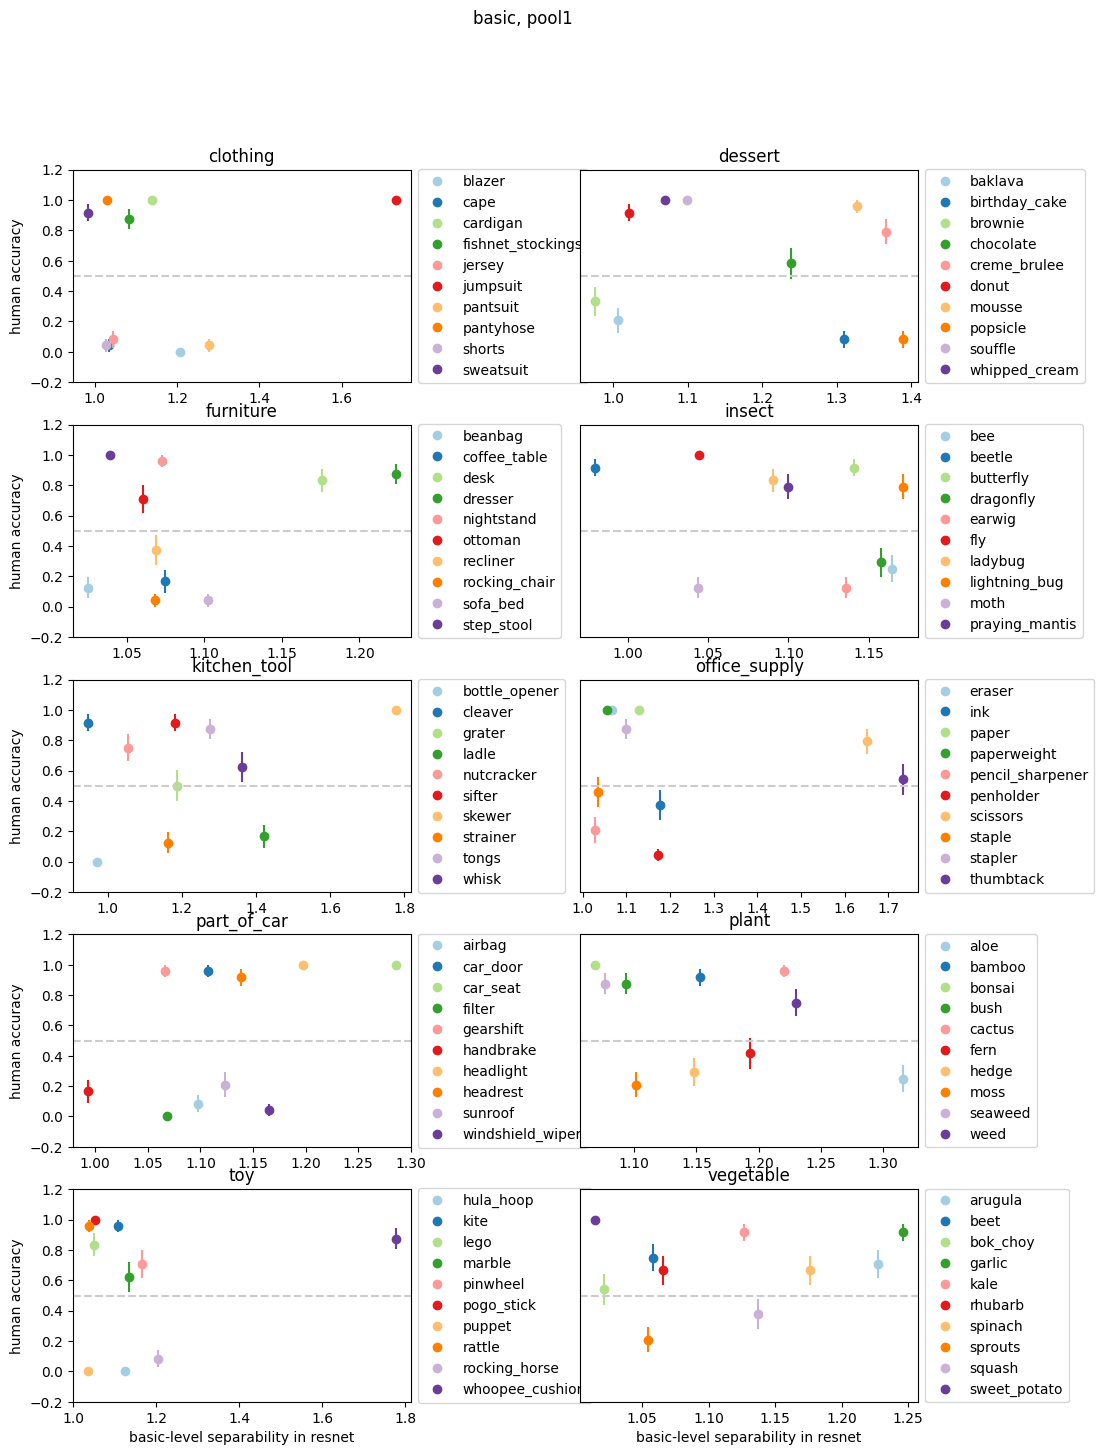

In [14]:
cc = 0;
ii = 0;

for cbi in [0,1]:
    
    supnames = super_names[super_cbinds==cbi]
      
    plt.figure(figsize=(12,16))

    pi=0
    
    for sc, supcat in enumerate(supnames):
    
        bnames = basic_names[super_names_long==supcat]
                
        pi+=1
        ax = plt.subplot(5,2,pi)

        # [subjects x basic_categ]
        vals = acc_by_bascat[cbi][:,cc,ii,sc,:]
        # plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
        plot_vals = vals
        meanvals = np.mean(plot_vals, axis=0)
        semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

        n_subs_plot = vals.shape[0]

        dist = basic_sep[super_inds_long==sc]

        basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
        # markertypes = np.tile(['.','x','^'],4) 
        markertypes = np.tile(['o'],10) 
        allh = []
        for bi in range(len(dist)):

            h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
            plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

            allh+=[h]

        plt.title('%s'%(supcat))

        plt.ylim([-0.2, 1.2])
        # plt.xlim([1.0, 2.5])
        if sc>7:
            plt.xlabel('basic-level separability in resnet')
        if np.mod(sc,2)==0:
            plt.ylabel('human accuracy')
        else:
            plt.yticks([])
            
        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')

        box = ax.get_position()
        ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

        # Put a legend to the right of the current axis
        ax.legend(allh, bnames, loc='center left', bbox_to_anchor=(1, 0.5))

    plt.suptitle('%s, %s'%(cue_level_vals[cc], image_type_names[ii]))
        # plt.legend(allh, bnames)

#### Plot behavioral accuracy versus category separability

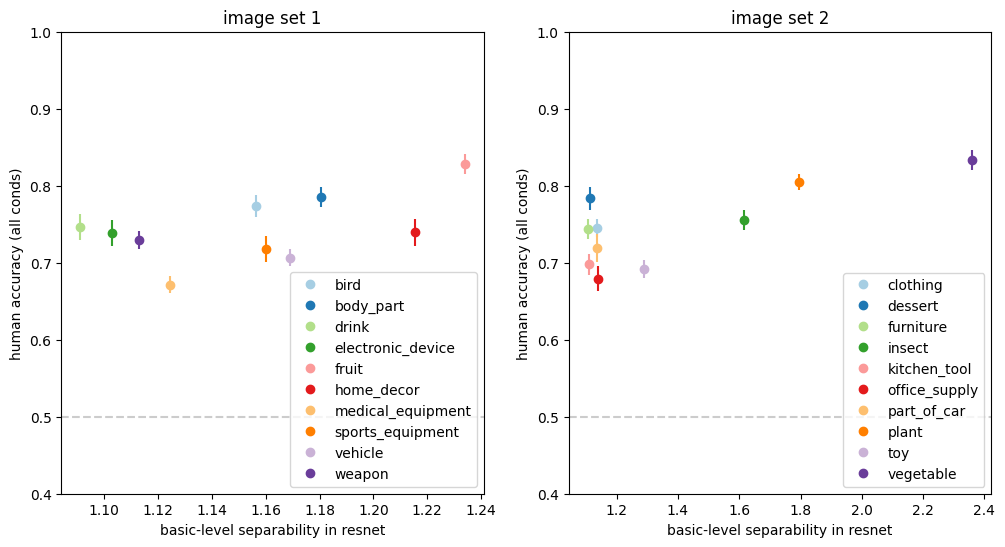

In [15]:
plt.figure(figsize=(12,6))

pi=0

for cbi in [0,1]:
        
    pi+=1
    ax = plt.subplot(1,2,pi)

    vals = acc_by_supcat[cbi]
    plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

    n_subs_plot = vals.shape[0]

    supnames = super_names[super_cbinds==cbi]

    dist = basic_sep_each_supcat[super_cbinds==cbi]

    basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
    # markertypes = np.tile(['.','x','^'],4) 
    markertypes = np.tile(['o'],10) 
    allh = []
    for bi in range(len(dist)):
        
        h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
        plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

        allh+=[h]
    
    plt.title('image set %d'%(cbi+1))

    plt.ylim([0.4, 1.0])
    # plt.xlim([1.0, 2.5])
    plt.xlabel('basic-level separability in resnet')
    plt.ylabel('human accuracy (all conds)')

    plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
   
    plt.legend(allh, supnames)

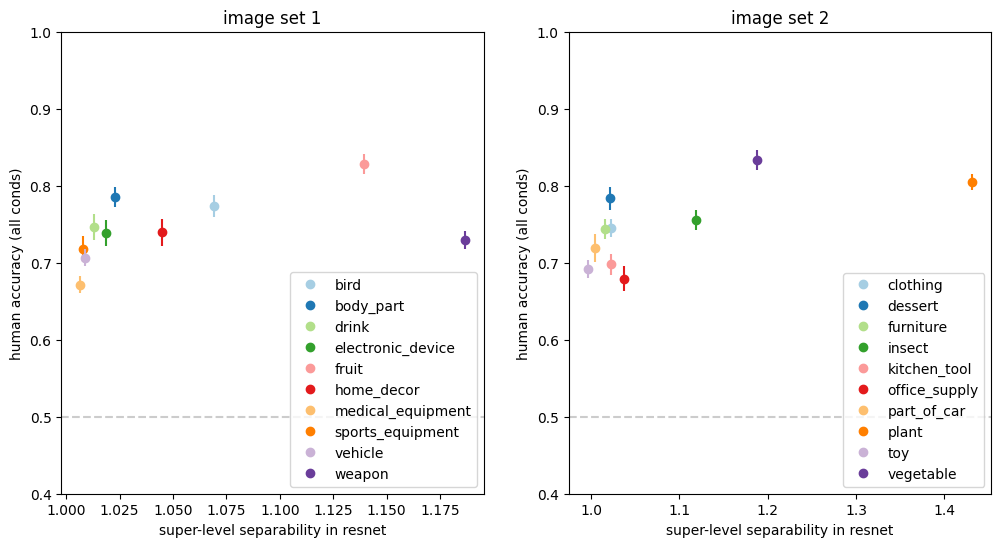

In [16]:
plt.figure(figsize=(12,6))

pi=0

for cbi in [0,1]:
        
    pi+=1
    ax = plt.subplot(1,2,pi)

    vals = acc_by_supcat[cbi]
    plot_vals = np.mean(np.mean(vals, axis=1), axis=1)
    meanvals = np.mean(plot_vals, axis=0)
    semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

    n_subs_plot = vals.shape[0]

    supnames = super_names[super_cbinds==cbi]

    dist = super_sep_each_supcat[super_cbinds==cbi]

    basic_colors = cm.Paired(np.linspace(0, 1, 12))[0:10,:]
    # markertypes = np.tile(['.','x','^'],4) 
    markertypes = np.tile(['o'],10) 
    allh = []
    for bi in range(len(dist)):
        
        h, = plt.plot(dist[bi], meanvals[bi], markertypes[bi], color=basic_colors[bi,:], alpha=1)
        plt.errorbar(dist[bi], meanvals[bi], semvals[bi], linestyle='none', color=basic_colors[bi,:])

        allh+=[h]
    
    plt.title('image set %d'%(cbi+1))

    plt.ylim([0.4, 1.0])
    # plt.xlim([1.0, 2.5])
    plt.xlabel('super-level separability in resnet')
    plt.ylabel('human accuracy (all conds)')

    plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
   
    plt.legend(allh, supnames)

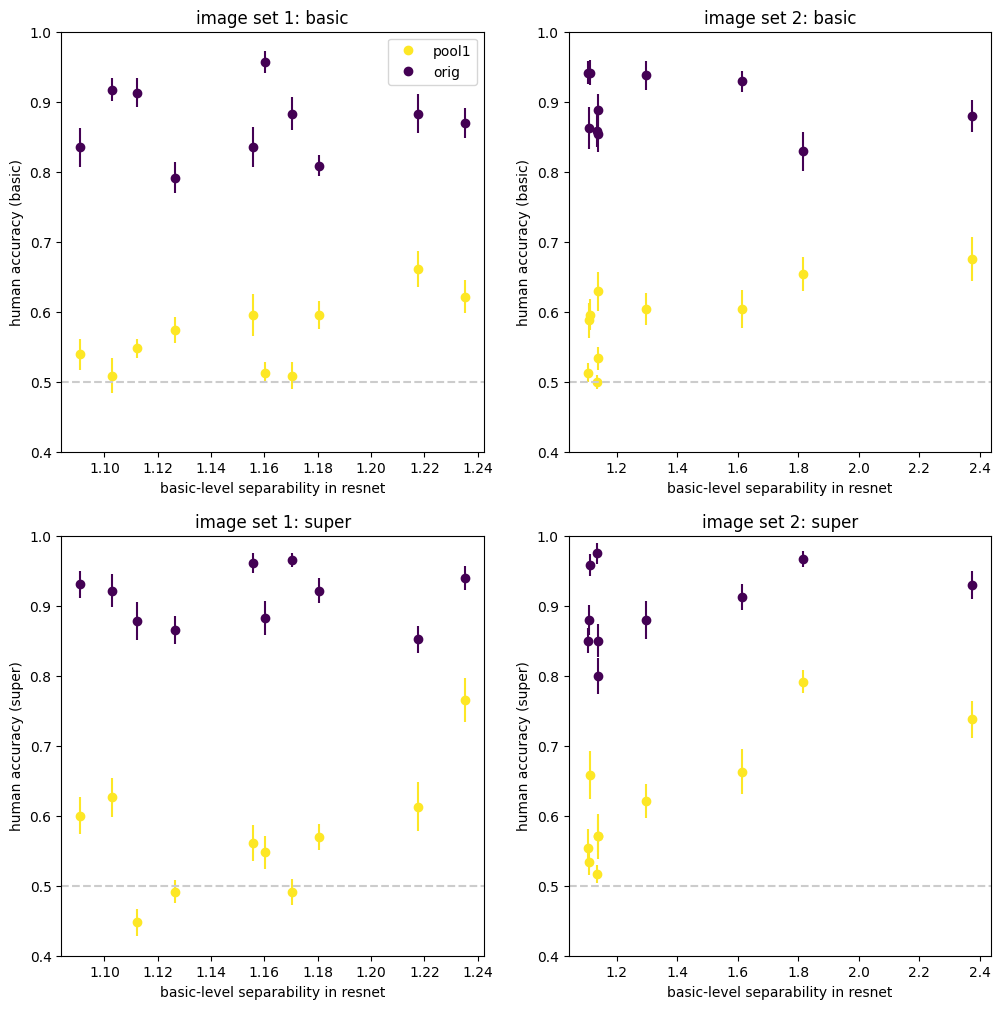

In [18]:
image_type_colors = np.flipud(cm.viridis(np.linspace(0,1,5)))

image_types_plot = [0,4]
# image_types_plot = [0,1,2,3,4]

plt.figure(figsize=(12,12))

pi=0
for cc in [0,1]:
    
    for cbi in [0,1]:
        
        pi+=1
        ax = plt.subplot(2,2,pi)
        
        vals = acc_by_supcat[cbi]
        n_subs_plot = vals.shape[0]
        
        supnames = super_names[super_cbinds==cbi]

        dist = basic_sep_each_supcat[super_cbinds==cbi]

        hlist = []
        for ii in image_types_plot:

            plot_vals = vals[:,cc,ii,:]
            meanvals = np.mean(plot_vals, axis=0)
            semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

            h, = plt.plot(dist, meanvals, 'o', color=image_type_colors[ii,:])
            plt.errorbar(dist, meanvals, semvals, linestyle='none', color=image_type_colors[ii,:])

            hlist+=[h]
        plt.title('image set %d: %s'%(cbi+1, cue_level_vals[cc]))

        plt.ylim([0.4, 1.0])
        # plt.xlim([1.0, 2.5])
        plt.xlabel('basic-level separability in resnet')
        plt.ylabel('human accuracy (%s)'%cue_level_vals[cc])

        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
        if pi==1:
            plt.legend(hlist,np.array(image_type_names)[image_types_plot])
        # plt.suptitle('Performance on %s, %s'%(image_type_names[ii], cue_level_vals[cc]))

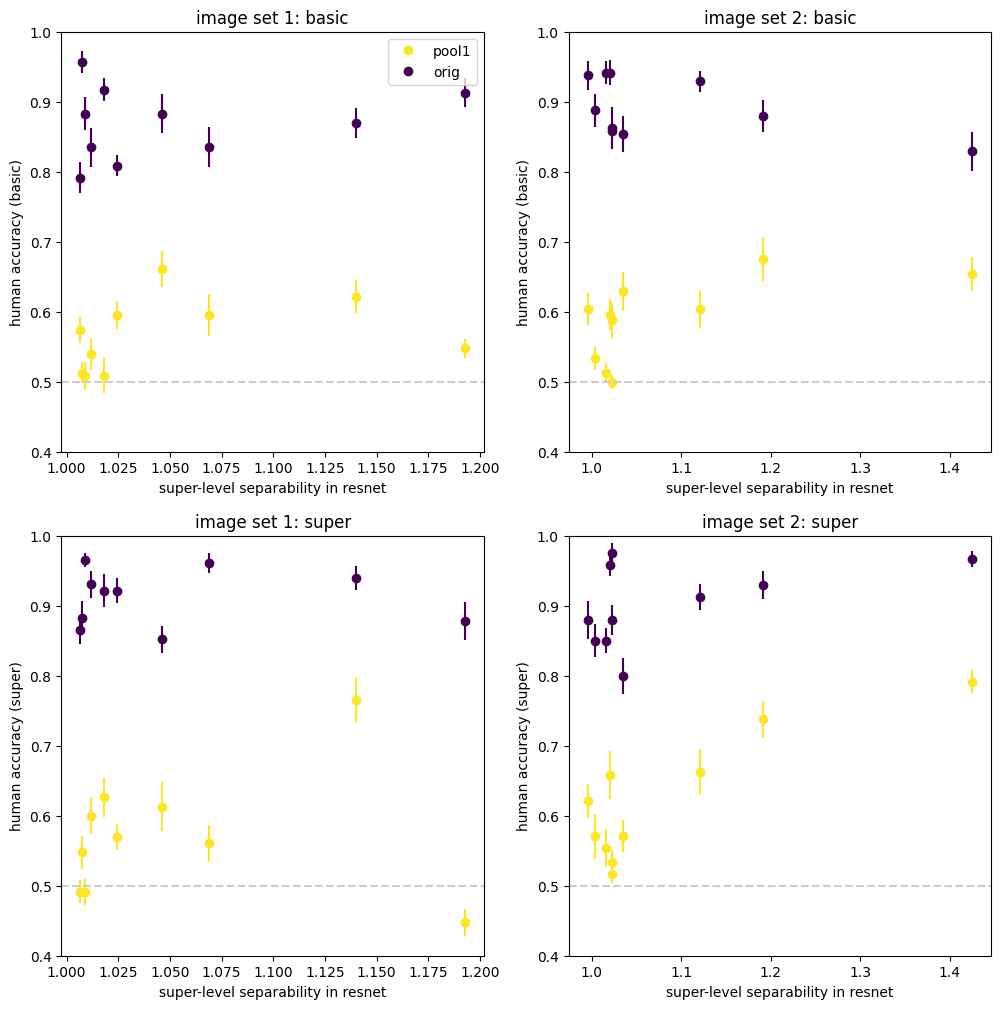

In [19]:
image_type_colors = np.flipud(cm.viridis(np.linspace(0,1,5)))

image_types_plot = [0,4]
# image_types_plot = [0,1,2,3,4]

plt.figure(figsize=(12,12))

pi=0
for cc in [0,1]:
    
    for cbi in [0,1]:
        
        pi+=1
        ax = plt.subplot(2,2,pi)
        
        vals = acc_by_supcat[cbi]
        n_subs_plot = vals.shape[0]
        
        supnames = super_names[super_cbinds==cbi]

        dist = super_sep_each_supcat[super_cbinds==cbi]

        hlist = []
        for ii in image_types_plot:

            plot_vals = vals[:,cc,ii,:]
            meanvals = np.mean(plot_vals, axis=0)
            semvals = np.std(plot_vals, axis=0)/np.sqrt(plot_vals.shape[0])

            h, = plt.plot(dist, meanvals, 'o', color=image_type_colors[ii,:])
            plt.errorbar(dist, meanvals, semvals, linestyle='none', color=image_type_colors[ii,:])

            hlist+=[h]
        plt.title('image set %d: %s'%(cbi+1, cue_level_vals[cc]))

        plt.ylim([0.4, 1.0])
        # plt.xlim([1.0, 2.5])
        plt.xlabel('super-level separability in resnet')
        plt.ylabel('human accuracy (%s)'%cue_level_vals[cc])

        plt.axhline(0.5, color=[0.8, 0.8, 0.8], linestyle='--')
        if pi==1:
            plt.legend(hlist,np.array(image_type_names)[image_types_plot])
        # plt.suptitle('Performance on %s, %s'%(image_type_names[ii], cue_level_vals[cc]))